In [10]:
import pandas as pd
import vaex
import os
import matplotlib.pyplot as plt
import datetime
from plotnine import *
import re

In [11]:
path = r"D:\datasets\mimiciii"
os.chdir(path)

In [12]:
sheets = os.listdir(path)
sheets

['ADMISSIONS.csv',
 'admission_adult.csv',
 'aline-dataset.csv',
 'CALLOUT.csv',
 'CAREGIVERS.csv',
 'chart.csv',
 'CHARTEVENTS.csv.hdf5',
 'CNS_BLOOD.CSV',
 'CPTEVENTS.csv',
 'DATETIMEEVENTS.csv',
 'datetimevents_item.csv',
 'DIAGNOSES_ICD.csv',
 'DRGCODES.csv',
 'drug_list.csv',
 'D_CPT.csv',
 'D_ICD_DIAGNOSES.csv',
 'D_ICD_PROCEDURES.csv',
 'D_ITEMS.csv',
 'D_LABITEMS.csv',
 'ICUSTAYS.csv',
 'INPUTEVENTS_CV.csv.hdf5',
 'INPUTEVENTS_MV.csv',
 'LABEVENTS.csv.hdf5',
 'microbiology.csv',
 'MICROBIOLOGYEVENTS.csv',
 'NOTEEVENTS.csv.hdf5',
 'OUTPUTEVENTS.csv',
 'PATIENTS.csv',
 'PATIENTS.csv.hdf5',
 'patients_info.csv',
 'patient_adult.csv',
 'poisonging.csv',
 'poisoning_diagnosis_mimiciii.csv',
 'prcedures.csv',
 'PRESCRIPTIONS.csv',
 'PROCEDUREEVENTS_MV.csv',
 'PROCEDURES_ICD.csv',
 'rtpa.xlsx',
 'SERVICES.csv',
 'TRANSFERS.csv',
 'trauma.csv',
 '中毒患者统计.xlsx',
 '中毒诊断列表.xlsx',
 '处置字典.xlsx',
 '病人情况.csv',
 '病原学种类.xlsx',
 '药物种类.xlsx',
 '血化验项目.xlsx',
 '项目种类.xlsx']

In [13]:
### 在入院表里找找出因急性外伤入院患者

#addmissions = pd.read_csv("patient_adult.csv",parse_dates=[3,4,5])     ### patient_adult 仅包含成人患者

## 新研究读取基本患者数据

addmissions = pd.read_csv("admission_adult.csv",parse_dates=[4,5,6,15,16,22,23,24])

addmissions.dropna(subset=["DIAGNOSIS"],inplace=True)

trauma = addmissions[addmissions.DIAGNOSIS.str.contains("injury|wound|trauma",flags=re.IGNORECASE,regex=True)]

trauma = trauma[trauma.ADMISSION_TYPE != "ELECTIVE"]

# trauma.columns

# trauma.HAS_CHARTEVENTS_DATA.value_counts()

trauma.DEATHTIME.isna().value_counts()

# addmissions.DEATHTIME.isna().value_counts()

True     930
False    110
Name: DEATHTIME, dtype: int64

In [43]:
trauma.to_csv("trauma_admissions.csv")

#### 删除3天内死亡样本

In [14]:
# under_3day = list(trauma[trauma.survive_days<=3].SUBJECT_ID.values)

In [15]:
# trauma = trauma[trauma.SUBJECT_ID.isin(under_3day) == False]

#### 读入各种字典

In [16]:
d_diagnosis_icd = pd.read_csv("D_ICD_DIAGNOSES.csv")

d_labitems = pd.read_csv("D_LABITEMS.csv")
d_labitems.dropna(subset=["LABEL"],inplace=True)

d_items = pd.read_csv("D_ITEMS.csv")
d_items.dropna(subset=["LABEL"],inplace=True)

d_cpt = pd.read_csv("D_CPT.csv")

d_procedures = pd.read_csv("D_ICD_PROCEDURES.csv")

#### 读入常用信息表  

In [17]:
## 化验
chartevent = vaex.open("CHARTEVENTS.csv.hdf5")
labevents = vaex.open("LABEVENTS.csv.hdf5")
## 入出液体
inputevents_cv = vaex.open("INPUTEVENTS_CV.csv.hdf5")    

In [19]:
start=time.time()
## 入出液体
inputevents_mv = pd.read_csv('INPUTEVENTS_MV.csv')
outputevents = pd.read_csv("OUTPUTEVENTS.csv")

##处置
procedureevents = pd.read_csv("PROCEDUREEVENTS_MV.csv")
procedure_icd = pd.read_csv("PROCEDURES_ICD.csv")

## 微生物学
microbiologyevents = pd.read_csv("MICROBIOLOGYEVENTS.csv")

##
datetimeevents = pd.read_csv("DATETIMEEVENTS.csv")
## 诊断
diagnoses_icd = pd.read_csv("DIAGNOSES_ICD.csv")

## 药物
prescriptions = pd.read_csv("PRESCRIPTIONS.csv",parse_dates=[4,5])

end=time.time()
print('Running time: %s Seconds'%(end-start))

Running time: 164.3562936782837 Seconds


#### 连接诊断代码及名称

In [20]:
df_with_diagnosis_icd = pd.merge(trauma,diagnoses_icd,how="inner",on="SUBJECT_ID")

df_with_diagnosis = pd.merge(df_with_diagnosis_icd,d_diagnosis_icd,how="left",on="ICD9_CODE")

df_with_diagnosis.dropna(subset=["LONG_TITLE"],inplace=True)

In [21]:
df_with_diagnosis.shape

(15463, 36)

#### 留取创伤相关诊断及病例号

In [22]:
df_dia_with_trauma = df_with_diagnosis[df_with_diagnosis.LONG_TITLE.str.contains("[I/i]njury|[w/W]ound|[T/t]rauma")]

In [14]:
# df_dia_with_trauma_1 = df_with_diagnosis[df_with_diagnosis.LONG_TITLE.str.contains("injury|wound|trauma",flags=re.IGNORECASE,regex=True)]

In [23]:
df_dia_with_trauma.shape

(2361, 36)

In [16]:
#df_dia_with_trauma_1.shape

(2361, 37)

In [17]:
### 比较两个DATAFRAME是否相同
from pandas.testing import assert_frame_equal

assert_frame_equal(df_dia_with_trauma,df_dia_with_trauma_1)

In [24]:
## 提取诊断名称列表并计数
list_diagnosis = df_dia_with_trauma.LONG_TITLE.value_counts()

pd.DataFrame(list_diagnosis).to_csv(r"F:\myresearch\TraumaHba1\data\list_diagnosis.csv")

In [25]:
pd.DataFrame(list_diagnosis)

,LONG_TITLE
Contusion of lung without mention of open wound into thorax,116
Traumatic pneumothorax without mention of open wound into thorax,113
"Open wound of scalp, without mention of complication",81
Closed fracture of dorsal [thoracic] vertebra without mention of spinal cord injury,69
Closed fracture of lumbar vertebra without mention of spinal cord injury,60
...,...
"Open wound of wrist, complicated",1
Crushing injury of scapular region,1
"Open wound of cheek, complicated",1
"Injury by handgun, undetermined whether accidentally or purposely inflicted",1


In [26]:
#list_diagnosis

In [27]:
pd.DataFrame(list_diagnosis).to_csv(r"F:\myresearch\TraumaHba1\data\list_diagnosis.csv")

In [28]:
"""
根据ids在相应表格里提取信息
table:DataFrame，表格名称，如：outputevents
column_name:字符串，提取依据所在列，如：SUBJECT_ID
ids:列表，提取依据，如：SUBJECT_ID,HADM_ID等
注意参数顺序
"""
def ExtractSamples(table,column_name,ids):
    table_extracted = table[table[column_name].isin(ids)]
    print("the table shape is :"+str(table_extracted.shape))
    return table_extracted

In [29]:
trauma_ids = trauma.SUBJECT_ID.values

In [30]:
chart_trauma = ExtractSamples(chartevent,"SUBJECT_ID",trauma_ids)

the table shape is :(10248448, 14)


In [31]:
chart_trauma.export_hdf5(r"F:\myresearch\TraumaHba1\data\trauma_chartevents.hdf5")

In [85]:
# ct = vaex.open(r"F:\myresearch\TraumaHba1\data\trauma_chartevents.hdf5")

In [32]:
labevents_trauma =  ExtractSamples(labevents,"SUBJECT_ID",trauma_ids)

labevents.export_csv(r"F:\myresearch\TraumaHba1\data\trauma_labevents.csv")

prescriptions_trauma = ExtractSamples(prescriptions,"SUBJECT_ID",trauma_ids)

prescriptions_trauma.to_csv(r"F:\myresearch\TraumaHba1\data\trauma_prescriptions.csv")

outputevents_trauma = ExtractSamples(outputevents,"SUBJECT_ID",trauma_ids)

outputevents_trauma.to_csv(r"F:\myresearch\TraumaHba1\data\trauma_outputevents.csv")

datetimeevents_trauma = ExtractSamples(datetimeevents,"SUBJECT_ID",trauma_ids)

datetimeevents_trauma.to_csv(r"F:\myresearch\TraumaHba1\data\trauma_datetimevents.csv")

trauma.to_csv(r"F:\myresearch\TraumaHba1\data\trauma_addmission.csv")


microbiology_trauma = ExtractSamples(microbiologyevents,"SUBJECT_ID",trauma_ids)

microbiology_trauma.to_csv(r"F:\myresearch\TraumaHba1\data\trauma_microbiology.csv")

inputevents_mv_trauma = ExtractSamples(inputevents_mv,"SUBJECT_ID",trauma_ids)
inputevents_cv_trauma = ExtractSamples(inputevents_cv,"SUBJECT_ID",trauma_ids)

inputevents_mv_trauma.to_csv(r"F:\myresearch\TraumaHba1\data\trauma_input_mv.csv")

inputevents_cv_trauma.export_csv(r"F:\myresearch\TraumaHba1\data\trauma_input_cv.csv")

procedure_mv_trauma = ExtractSamples(procedureevents,"SUBJECT_ID",trauma_ids)
procedure_icd_trauma = ExtractSamples(procedure_icd,"SUBJECT_ID",trauma_ids)

the table shape is :(688460, 9)
the table shape is :(114900, 19)
the table shape is :(152998, 13)
the table shape is :(152642, 14)
the table shape is :(20854, 16)
the table shape is :(139786, 31)
the table shape is :(543163, 22)
the table shape is :(9301, 25)
the table shape is :(7835, 5)


In [33]:
# procedure_mv_trauma.to_csv(r"F:\myresearch\TraumaHba1\data\trauma_procedure_mv.csv")
# procedure_icd_trauma.to_csv(r"F:\myresearch\TraumaHba1\data\trauma_procedure_icd.csv")

In [34]:
os.chdir(r"F:\myresearch\TraumaHba1\data")

pd.merge(pd.DataFrame(outputevents_trauma.ITEMID.drop_duplicates()),d_items,on="ITEMID").to_csv("outputevents.csv")

pd.merge(pd.DataFrame(inputevents_mv_trauma.ITEMID.drop_duplicates()),d_items,on="ITEMID").to_csv("input_mv.csv")

pd.merge(pd.DataFrame(procedure_mv_trauma.ITEMID.drop_duplicates()),d_items,on="ITEMID").to_csv("prcedures_mv.csv")

pd.merge(pd.DataFrame(procedure_icd_trauma.ICD9_CODE.drop_duplicates()),d_procedures,on="ICD9_CODE").to_csv("prcedures_icd.csv")

In [35]:
pd.merge(pd.DataFrame(datetimeevents_trauma.ITEMID.drop_duplicates()),d_items,on="ITEMID").to_excel("dateimeevent.xlsx")

In [55]:
## vaex 的hdf5格式文件需要单独处理

# inputevents_cv_trauma.join(vaex.from_pandas(d_items),on="ITEMID",lsuffix="_l",rsuffix="_r",allow_duplication="False")

(543163, 32)

In [36]:
## 转为pd DataFrame 再处理也行
pd.merge(inputevents_cv_trauma.to_pandas_df().ITEMID.drop_duplicates(),d_items,on="ITEMID").to_csv("input_cv.csv")

In [37]:
pd.merge(pd.DataFrame(procedure_icd_trauma.ICD9_CODE.drop_duplicates()),d_procedures,on="ICD9_CODE").shape

(738, 4)

In [42]:
pd.merge(pd.DataFrame({"ITEMID":chart_trauma.ITEMID.value_counts().index}),d_items,on="ITEMID").to_excel("CHART.xlsx")

C:\ProgramData\Anaconda3\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 14'. Pick better value with 'binwidth'.
INFO:MainThread:numexpr.utils:NumExpr defaulting to 2 threads.


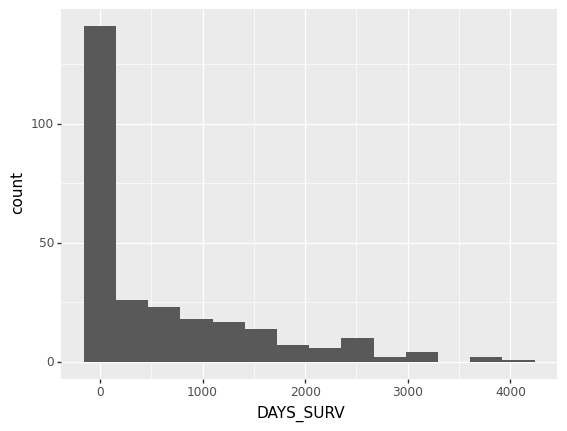

<ggplot: (133519511462)>

In [41]:
(
    ggplot(trauma[trauma["DAYS_SURV"].notna()], aes(x='DAYS_SURV'))
    + geom_histogram()
)